In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/src/analysis/round2'

In [9]:
df1 = pd.read_csv('../../../data/round-2-island-data-bottle/prices_round_2_day_-1.csv', delimiter=';')
df2 = pd.read_csv('../../../data/round-2-island-data-bottle/prices_round_2_day_0.csv', delimiter=';')
df3 = pd.read_csv('../../../data/round-2-island-data-bottle/prices_round_2_day_1.csv', delimiter=';')
df = pd.concat([df1, df2, df3])

In [10]:
print(df)

       day  timestamp           product  bid_price_1  bid_volume_1  \
0       -1          0        CROISSANTS         4304           112   
1       -1          0              JAMS         6670            66   
2       -1          0         SQUID_INK         2005             1   
3       -1          0    PICNIC_BASKET1        59284            20   
4       -1          0    PICNIC_BASKET2        30606            20   
...    ...        ...               ...          ...           ...   
79995    1     999900              JAMS         6519           204   
79996    1     999900  RAINFOREST_RESIN         9995            20   
79997    1     999900         SQUID_INK         1799            20   
79998    1     999900    PICNIC_BASKET1        58713            15   
79999    1     999900    PICNIC_BASKET2        30100            36   

       bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0              NaN           NaN          NaN           NaN         4305   
1      

In [27]:
def extract_product(df, product_name: str):
    df = df.copy()
    df_product = df[df['product'] == product_name]
    return df_product

In [25]:
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """

    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = min(bid_prices) if bid_prices else None

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = max(ask_prices) if ask_prices else None
        
        # 计算价差
        spread = best_ask - best_bid
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df
    

In [ ]:
product_list = df['product'].unique()
print(product_list)
product_dfs = {}
for product in product_list:
    product_df = extract_product(df, product)
    product_df.set_index('timestamp', inplace=True)
    product_dfs[product] = orderbook_preprocess(product_df)

    

['CROISSANTS' 'JAMS' 'SQUID_INK' 'PICNIC_BASKET1' 'PICNIC_BASKET2'
 'RAINFOREST_RESIN' 'DJEMBES' 'KELP']
CROISSANTS 30000
JAMS 30000
SQUID_INK 30000
PICNIC_BASKET1 30000
PICNIC_BASKET2 30000
RAINFOREST_RESIN 30000
DJEMBES 30000
KELP 30000


In [46]:
df_croiss = product_dfs['CROISSANTS']
df_jams = product_dfs['JAMS']
df_basket1 = product_dfs['PICNIC_BASKET1']

df_djembes = product_dfs['DJEMBES']
df_basket2 = product_dfs['PICNIC_BASKET2']

In [47]:
print(df_basket1.columns)

Index(['day', 'product', 'bid_price_1', 'bid_volume_1', 'bid_price_2',
       'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1',
       'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3',
       'ask_volume_3', 'mid_price', 'profit_and_loss', 'best_bid', 'best_ask',
       'spread', 'vwap', 'orderbook_imbalance', 'ask_volume', 'bid_volume',
       'ask_bid_ratio'],
      dtype='object')


In [48]:
composite1 = 6*df_croiss['mid_price'] + 3*df_jams['mid_price'] + df_djembes['mid_price']
composite2 = 4*df_croiss['mid_price'] + 2*df_jams['mid_price'] 

In [49]:
print(df_croiss['mid_price'][:5])
print(df_jams['mid_price'][:5])
print(df_djembes['mid_price'][:5])

timestamp
0      4304.5
100    4304.5
200    4304.5
300    4304.5
400    4305.5
Name: mid_price, dtype: float64
timestamp
0      6670.5
100    6670.5
200    6671.0
300    6672.0
400    6672.0
Name: mid_price, dtype: float64
timestamp
0      13450.5
100    13450.0
200    13450.5
300    13450.0
400    13452.5
Name: mid_price, dtype: float64


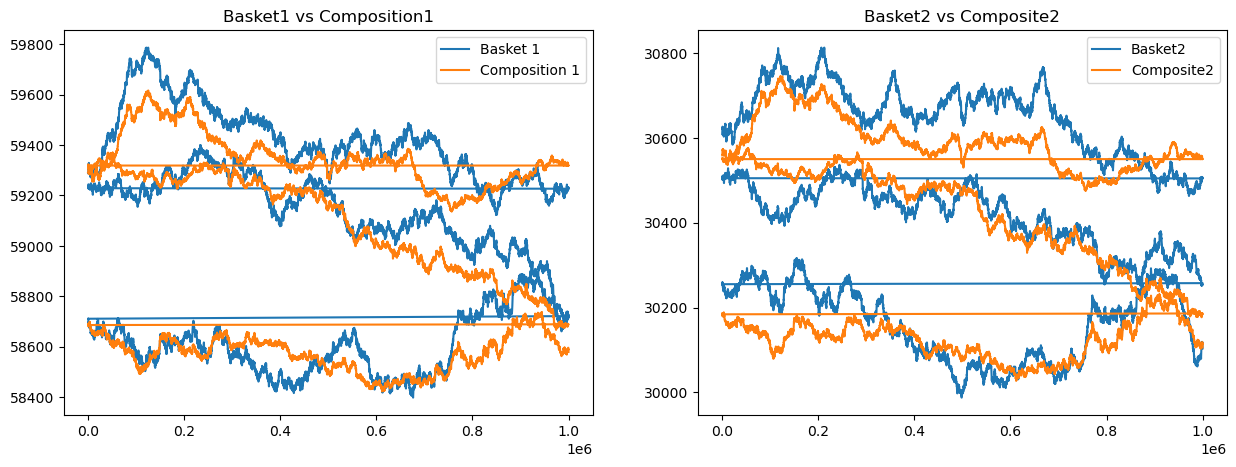

In [66]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Basket1 vs Composition1')
plt.plot(df_basket1['mid_price'], label = 'Basket 1')
plt.plot(composite1, label = 'Composition 1')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Basket2 vs Composite2')
plt.plot(df_basket2['mid_price'], label = 'Basket2')
plt.plot(composite2, label = 'Composite2')

plt.legend()
plt.show()

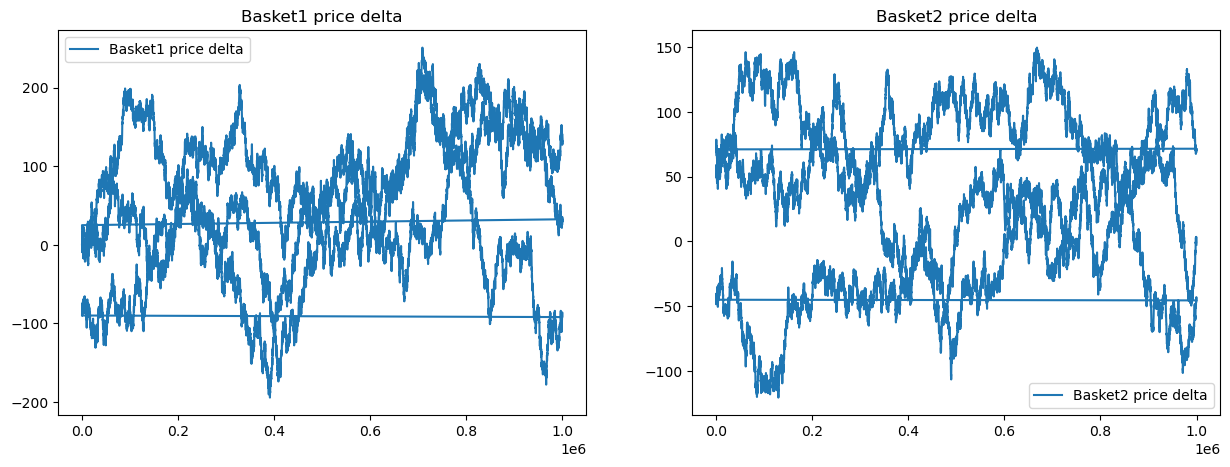

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Basket1 price delta')
plt.plot(df_basket1['mid_price'] - composite1, label = 'Basket1 price delta')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Basket2 price delta')
plt.plot(df_basket2['mid_price'] - composite2, label = 'Basket2 price delta')


plt.legend()
plt.show()

In [68]:
df_croiss1 = df_croiss.loc[df_croiss['day'] == 1]
df_jams1 = df_jams.loc[df_jams['day'] == 1]
df_djembes1 = df_djembes.loc[df_djembes['day'] == 1]


df_basket11 = df_basket1[df_basket1['day'] == 1]
df_basket21 = df_basket2[df_basket2['day'] == 1]

composite11 = 6*df_croiss1['mid_price'] + 3*df_jams1['mid_price'] + df_djembes1['mid_price']
composite21 = 4*df_croiss1['mid_price'] + 2*df_jams1['mid_price'] 

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Basket1 price delta')
plt.plot(df_basket11['mid_price'] - composite11, label = 'Basket1 price delta')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Basket2 price delta')
plt.plot(df_basket21['mid_price'] - composite21, label = 'Basket2 price delta')


plt.legend()
plt.show()